In [3]:
import cv2
import copy
import numpy as np

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
from torchvision import models as torch_models
from torchvision.datasets import ImageFolder

%matplotlib notebook
import matplotlib.pyplot as plt

seed = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SAVE = False
LOAD = True

# First Attempts

In [2]:
dset = []
filenames = []
! unzip -qn EyesDataset.zip
for file in Path('EyesDataset').iterdir():
    filenames.append(str(file))
    img = cv2.imread(str(file))
    dset.append(img)
    
dset = np.array(dset, dtype='f4') / 255
dset_flat = dset.reshape(len(dset), -1)

<IPython.core.display.Javascript object>


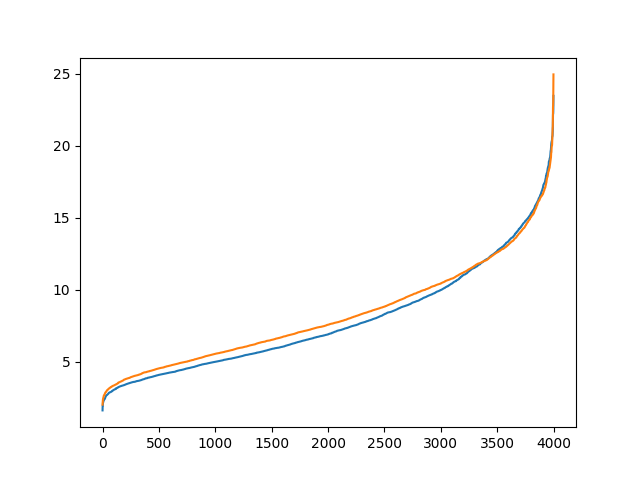

0.4735


In [3]:
kmeans = KMeans(n_clusters=2, random_state=seed).fit(dset_flat)
dist = kmeans.transform(dset_flat)

plt.figure()
plt.plot(np.sort(dist[:, 0]));
plt.plot(np.sort(dist[:, 1]));

labels = kmeans.labels_ 
print(labels.sum()/labels.size)

<IPython.core.display.Javascript object>


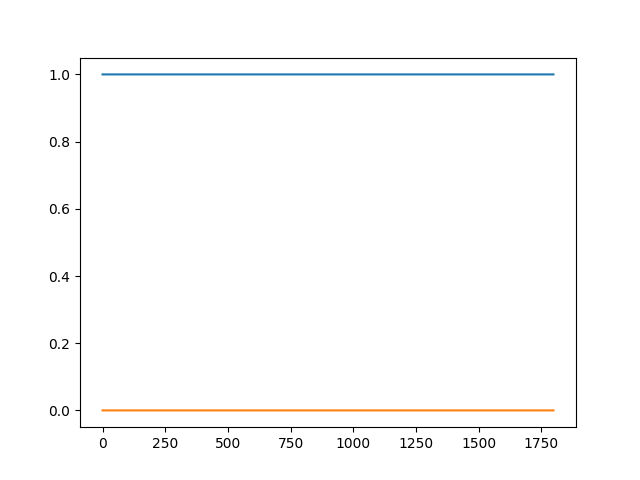

In [4]:
n_samples = 1800
ids1 = np.argsort(dist[:,1] - dist[:,0])[:n_samples]
ids0 = np.argsort(dist[:,0] - dist[:,1])[:n_samples]

plt.figure()
plt.plot(labels[ids1]);
plt.plot(labels[ids0]);

<IPython.core.display.Javascript object>


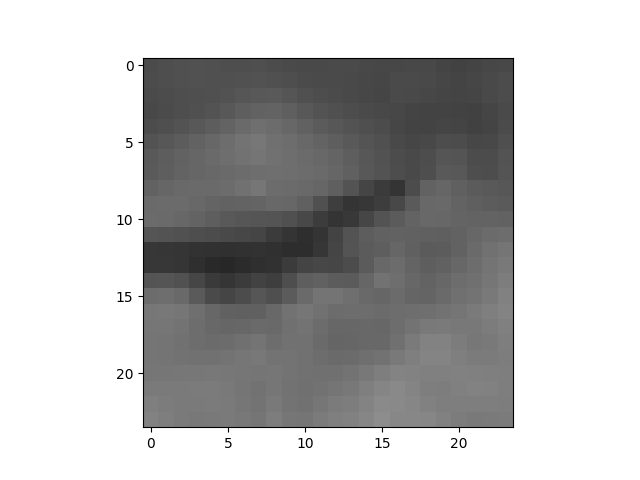

In [5]:
mask1 = labels.astype('bool')
plt.figure()
plt.imshow(dset[~mask1][32]);

In [28]:
X = dset.transpose(0, 3, 1, 2)
y = labels

X_train, X_test, y_train, y_test = map(torch.Tensor,
    train_test_split(X, y, test_size=.2, random_state=seed))

In [7]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3, 32, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(.2),

            nn.Conv2d(
                32, 16, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(.2),

            nn.Conv2d(
                16, 8, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(.2),

            nn.Conv2d(
                8, 4, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(.2),
            
            nn.Conv2d(4, 1, kernel_size=2)
        )
        
    def forward(self, X):
        return self.main(X).flatten()
    
    def predict(self, X):
        return self.forward(X).sigmoid()

In [8]:
class BatchLoader:
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self._reinit()
        
    def __len__(self):
        return len(self.y) // self.batch_size

    def _gen(self):
        bs = self.batch_size  # alias
        ids = np.arange(len(self.y))
        np.random.shuffle(ids)

        for i in range(0, len(self.y), bs):
            yield self.X[i:i+bs], self.y[i:i+bs]
            
        self._reinit()

    def _reinit(self):
        self.gen = self._gen()
        
    def __iter__(self):
        return self.gen

In [9]:
def ROC_EER(y_true, y_pred, return_roc=False):
    if isinstance(y_pred, torch.Tensor):
        y_true = y_true.cpu()
        y_pred = y_pred.detach().cpu()
        
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    eer = fpr[np.nanargmin(np.absolute(1 - tpr - fpr))]
    if return_roc: return eer, fpr, tpr
    return eer

In [10]:
def train(
    net, criterion, optimizer, train_bl, val_bl,
    scheduler=None, epochs=10, verbose=True,
    validation='EER', best_val_score=None):

    if verbose:
        print('Epoch\t\tTrain\t\tValidation')
        if validation == 'EER': print('\t\t\t\tBCE\tEER')
        print()

    if best_val_score is None:
        best_val_score = float('inf')
        best_model_state = None

    for epoch in range(1, epochs+1):
        train_loss = val_loss = 0
        net.train()

        for X,y in train_bl:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device)

            loss = criterion(net(X), y)
            loss.backward()
            train_loss += loss.item() * len(y)/train_bl.batch_size

            optimizer.step()
        train_loss /= len(train_bl)

        net.eval()
        Y = torch.Tensor([])
        Y_pred = torch.Tensor([])

        for X,y in val_bl:
            Y = torch.cat((Y, y))
            X, y = X.to(device), y.to(device)

            y_pred = net(X)
            Y_pred = torch.cat((Y_pred, y_pred.detach().cpu()))
            loss = criterion(y_pred, y)

            val_loss += loss.item() * len(y)/val_bl.batch_size

        val_loss /= len(val_bl)
        val_score = val_loss
        if validation == 'EER':
            val_score = ROC_EER(Y, Y_pred)

        if val_score < best_val_score:
            best_val_score = val_score
            best_model_state = copy.deepcopy(net.state_dict())

        if scheduler is not None: scheduler.step()

        freq = max(epochs//20, 1)
        if verbose and epoch % freq == 0:
            logline = f'{epoch}/{epochs}\t\t{train_loss:.4}\t\t{val_loss:.4f}'
            if validation == 'EER': logline += f'\t{val_score:.4}'
            print(logline)

    return best_val_score, best_model_state

In [11]:
class LabelSmoothedBCEwLL(nn.BCEWithLogitsLoss):
    """
    In this implementation, the effect of label smoothing is
    taken into account in the regularization term. This loss
    is completely equivalent to the actual label smoothing
    implemented below, when the hyperparmeter epsilon is
    twice as the commented out one.
    """
    def __init__(self, eps=.2):
        super().__init__()
        self.eps = eps
        
    def forward(self, input, target):
        base_loss = super().forward(input, target)
        dummy_target = torch.empty_like(target).fill_(.5)
        reg_term = super().forward(input, dummy_target)
        return (1-self.eps)*base_loss + self.eps*reg_term

# class LabelSmoothedBCEwLL(nn.BCEWithLogitsLoss):
#     def __init__(self, eps=.1):
#         super().__init__()
#         self.eps = eps
        
#     def forward(self, input, target):
#         target = target.clone()
#         target[np.where(target == 0)] = self.eps
#         target[np.where(target == 1)] = 1 - self.eps
#         return super().forward(input, target)

In [12]:
label_smoothing = True

net = SimpleNet().to(device)
opt = optim.Adam(net.parameters(), lr=3e-3)

criterion = nn.BCEWithLogitsLoss()
if label_smoothing:
    criterion = LabelSmoothedBCEwLL(.4)

train_bl = BatchLoader(X_train, y_train, 40)
val_bl = BatchLoader(X_test, y_test, 100)

In [13]:
_, state = train(net, criterion, opt, train_bl, val_bl, epochs=10, validation='EER')
if SAVE: torch.save(state, 'weights.pth')

Epoch		Train		Validation
				BCE	EER

1/10		0.5468		0.5282	0.03061
2/10		0.5369		0.5247	0.02551
3/10		0.5342		0.5234	0.02551
4/10		0.5329		0.5222	0.02296
5/10		0.5316		0.5224	0.02296
6/10		0.5307		0.5233	0.02296
7/10		0.5298		0.5220	0.02296
8/10		0.5291		0.5213	0.02041
9/10		0.5285		0.5241	0.02296
10/10		0.5277		0.5270	0.02296


In [14]:
if LOAD:
    net = SimpleNet()
    net.load_state_dict(
        torch.load('weights.pth', map_location=device))

In [15]:
y_pred = net.predict(X_test)
eer, fpr, tpr = ROC_EER(y_test, y_pred, return_roc=True)

EER = 0.01488833746898263


<IPython.core.display.Javascript object>


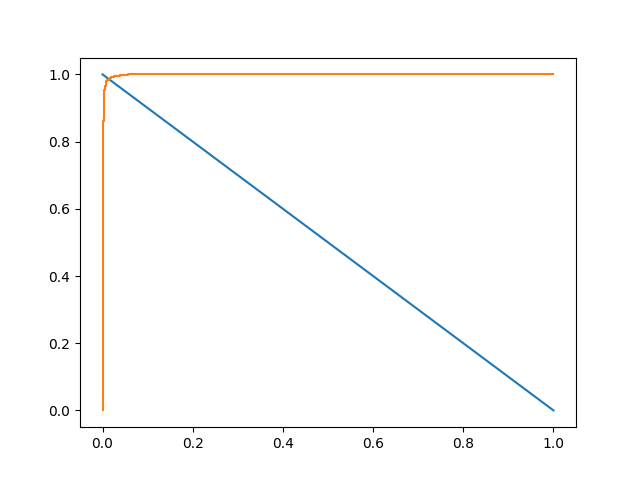

In [31]:
x = np.linspace(0, 1, num=len(fpr))
print('EER =', eer)

plt.figure()
plt.plot(x, 1-x);
plt.plot(fpr, tpr);

# Manual Labeling

In [17]:
def rectify_labels(X, y, i_start=0, max_iters=None):
    """
    A tool for manual labeling in Jupyter Notebook
    """
    fig, ax = plt.subplots()

    y_upd = copy.deepcopy(y)
    Xinit = X[0].permute(1, 2, 0)
    img = ax.imshow(Xinit)
    break_flag = False
    
    try:
        for i in range(i_start, len(y)):
            img.set_data(X[i].permute(1, 2, 0))
            ax.set_title(f'y={y[i]}')
            fig.canvas.draw()
            res = input().strip()
            if res:
                if int(res) in [0, 1]:
                    y_upd[i] = int(res)
                else:
                    y_upd[i] = 1
                    print('Considering input as 1')

            if ((max_iters is not None)
                and (i - i_start >= max_iters-1)):
                break_flag = True
                break

    except KeyboardInterrupt: pass
    finally: return i+1, break_flag, y_upd

In [18]:
def mend_labels(X, y, clear_after=5):
    """
    Wrapper over `rectify_labels`
    preventing the input bar from running far down 
    """
    i_end = 0
    y_upd = copy.deepcopy(y)
    break_flag = True
    

    while break_flag:
        i_end, break_flag, y_upd = rectify_labels(
            X, y_upd, i_end, max_iters=clear_after)
        clear_output()

    return y_upd

# Third-Party Dataset

In [4]:
class MRLEyesData(torch_data.Dataset):
    def __init__(self, root_dir=None, fnames=None):
        super().__init__()
        if root_dir is not None:
            self.fnames = list(Path(root_dir).rglob('*.png'))
        elif fnames is not None:
            self.fnames = fnames
        else:
            raise ValueError(
                'root_dir or fnames '
                'should be specified')

        self.targets = []
        for fname in self.fnames:
            self.targets.append(float(fname.stem.split('_')[4]))

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        target = self.targets[idx]
        
        img = cv2.imread(str(fname))
        img = cv2.resize(img, (24, 24))
        img = img.transpose(2, 0, 1).astype('f4') / 255
        return img, target

In [5]:
! wget -nc http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip
fnames = list(Path('mrlEyes_2018_01').rglob('*.png'))
X_train, X_test = train_test_split(fnames, test_size=.2)

File ‘mrlEyes_2018_01.zip’ already there; not retrieving.



In [21]:
train_ds = MRLEyesData(fnames=X_train)
val_ds = MRLEyesData(fnames=X_train)

train_bl = torch_data.DataLoader(train_ds, batch_size=100, shuffle=True)
val_bl = torch_data.DataLoader(val_ds, batch_size=100, shuffle=True)

print(sum(train_ds.targets) / len(train_ds))

0.5051238257899231


In [22]:
if SAVE:
    X, y = next(iter(dloader))
    np.savez('mrleye_valset', X=X, y=y)

In [23]:
if LOAD:
    data = np.load('mrleye_valset.npz')
    X_test = torch.Tensor(data['X'])
    y_test = torch.Tensor(data['y'])

In [24]:
label_smoothing = False

net = SimpleNet().to(device)
opt = optim.Adam(net.parameters(), lr=3e-3)

criterion = nn.BCEWithLogitsLoss()
if label_smoothing:
    criterion = LabelSmoothedBCEwLL(.4)

In [25]:
_, state = train(net, criterion, opt, train_bl, val_bl, epochs=10, validation=None)

Epoch		Train		Validation

1/10		0.1519		0.1014
2/10		0.09194		0.0796
3/10		0.07893		0.0944
4/10		0.07202		0.0845
5/10		0.0657		0.0690
6/10		0.06143		0.0549
7/10		0.0567		0.0523
8/10		0.05514		0.0562
9/10		0.05158		0.0545
10/10		0.05108		0.0471
